In [4]:
import os
import cv2
import math
import time
import random
import h5py

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm_notebook

In [5]:
iN = np.hstack((np.array(1),np.arange(1,96))).astype('float32')

In [6]:
iN

array([ 1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95.], dtype=float32)

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [5]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

create_image_rows = 420
create_image_cols = 580
smooth = 1.0

In [4]:
#image_t =h5py.File('./imgs_train_3.h5', 'r')
#image_t =image_t.get('image')
#image_t= np.array(image_t)
#image_t=np.transpose(image_t)

In [6]:
mask_t = np.load('./imgs_mask_train.npy')
image_t = np.load('./imgs_train.npy')
#image_c = np.load('./image_FROST_9.npy')

random.seed(42)
suffle_seed = 42

In [7]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [8]:
def Frost_filter(img, winsize):
    eps = np.finfo(float).eps
    imageType = img.dtype
    mask = cv2.getStructuringElement(cv2.MORPH_RECT, (winsize, winsize))
    origin_gray = np.pad(img, (math.floor(winsize/2),
                               math.floor(winsize/2)), 'symmetric')
    origin_gray = origin_gray.astype('float32')
    [nRows, nCols] = np.shape(origin_gray)

    output_image = np.zeros((nRows, nCols))

    half_under = math.floor(winsize/2)
    half_upper = math.ceil(winsize/2)
    winsize_sq= winsize**2

    grid_size = np.arange(-math.floor(winsize/2), math.floor(winsize/2)+1, 1)
    [xIndGrid, yIndGrid] = np.meshgrid(grid_size, grid_size)
    expWeight = np.exp(-(xIndGrid**2 + yIndGrid**2)**0.5)

    ind = np.arange(math.ceil(winsize/2), nRows-math.floor(winsize/2))
    for i in ind:
        for j in ind:
            localNeighborhood = origin_gray[i-half_upper: i +half_under,
                                            j-half_upper: j+half_under]
            localNeighborhood = localNeighborhood.reshape(winsize_sq, 1)
            localMean = localNeighborhood.mean()
            localVar = localNeighborhood.var()+eps
            alpha = np.sqrt(localVar)/localMean
            localWeight = alpha*(expWeight**alpha)
            localWeightLin = localWeight.reshape(winsize_sq, 1)
            localWeightLin =localWeightLin/np.sum(localWeightLin)
            output_image[i, j] = np.sum(localWeightLin*localNeighborhood)

    output_image = output_image[math.floor(
        winsize/2):nRows-math.floor(winsize/2), math.floor(winsize/2):nCols-math.floor(winsize/2)]
    output_image = output_image.astype(imageType)

    return output_image

In [9]:
def kuan_filt(origin_gray, niterations):
    [x, y] = np.shape(origin_gray)
    I = origin_gray.astype('float32')
    kn = I
    N = np.zeros(np.shape(I))
    I = np.pad(I, (1, 1), 'reflect')
    for i in np.arange(0, niterations):
        if i >= 1:
            I = kn
        for i in np.arange(0, x):
            for j in np.arange(0, y):
                if (i == 0 and j == 0):
                    mat = np.array([0, 0, 0, 0, I[i, j], I[i, j+1],
                                    0, I[i+1, j], I[i+1, j+1]])
                if (i == 0 and j == y-1):
                    mat = np.array([0, 0, 0, I[i, j-1], I[i, j],
                                    0, I[i+1, j-1], I[i+1, j], 0])
                if (i == x-1 and j == 1):
                    mat = np.array([0, I[i-1, j], I[i-1, j+1], 0,
                                    I[i, j], I[i, j+1], 0, 0, 0])
                if (i == x-1 and j == y-1):
                    mat = np.array([I[i-1, j-1], I[i-1, j], 0,
                                    I[i, j-1], I[i, j], 0, 0, 0, 0])
                if (i > 0 and i < x-1 and j > 0 and j < y-1):
                    mat = np.array([I[i-1, j-1], I[i-1, j], I[i-1, j+1], I[i, j-1],
                                    I[i, j], I[i, j+1], I[i+1, j-1], I[i+1, j], I[i+1, j]])
                y1 = I[i, j]
                ybar = np.average((mat))
                ystad = np.std(mat)
                ENL=(ybar/ystad)**2
                sx2=((ENL*((ystad)**2))-((ybar)**2))/(ENL+1)
                xcap=ybar+(sx2*(y1-ybar))/(sx2+((ybar**2+sx2)/ENL))
                # N[i,j]=xcap
    return N

In [10]:
def SRAD(i, niter, lamda, rect):
    # make image a double and normalize on[0, 1]
    i = image_t[0].astype('float64')
    mx = np.max(i[:])
    mn = np.min(img[:])
    i = (i-mn)/(mx-mn)

    # make image a double and normalize on[0, 1]
    [M, N] = np.shape(i)

    # image indices (using boudary conditions)
    iN = np.hstack((np.array(0),np.arange(0,M-1)))
    iS = np.hstack((np.arange(1,M-1),np.array(M-1),np.array(M-1)))
    jW = np.hstack((np.array(0),np.arange(0,N-1)))
    jE = np.hstack((np.arange(1,N-1),np.array(N-1),np.array(N-1)))
    
    # log uncompress (also eliminates zero value pixels)
    img = np.exp(img)

    # main algorithm
    for liter in np.arange(1,niter+1):

         # speckle scale function
        Iuniform = img[rect[0]:rect[1],rect[2]:rect[3]]
        q0_squared = np.var(Iuniform[:]) / ((np.mean(Iuniform[:]))**2)

        # difference
        dN = i[iN, :] - i
        dS = i[iS, :] - i
        dW = i[:, jW] - i
        dE = i[:, jE] - i

        # normalized discrete gradient magnitude squared (equ 52,53)
        G2 = (pow(dN,2) + pow(dS, 2) + pow(dW, 2) + pow(dE, 2)) / (pow(i, 2))

        # normalized discrete laplacian (equ 54)
        L = (dN + dS + dW + dE)/img

        # ICOV (equ 31/35)
        num = (0.5*G2) - ((1/16)*(pow(L, 2)))
        den = pow((1 + ((1/4)*L)), 2)
        q_squared = num / (den + np.finfo(float).eps)

        # diffusion coefficent (equ 33)
        den = (q_squared - q0_squared) / (q0_squared * (1 + q0_squared) +np.finfo(float).eps)
        c = 1 / (1 + den)

        # saturate diffusion coefficent
        c[c < 0] = 0
        c[c > 1] = 1

        # divergence (equ 58)
        cS = c[iS, :]
        cE = c[:,jE]
        D = (c*dN) + (cS*dS) + (c*dW) + (cE*dE)
        
        # update
        img = img + (lamda/4)*D; 
        
    J = np.log(img)
    J=np.round(J*255)
    return J

In [11]:
import scipy
train_image_rows = 96
train_image_cols = 96
winodw_size = 3

def preprocess_msk(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.uint8)
    for i in tqdm_notebook(range(imgs.shape[0])):
        imgs_p[i] = resize(
            imgs[i].astype('float32'), (train_image_rows, train_image_cols), mode='reflect',
            preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #imgs[i] = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        imgs_t = SRAD(imgs[i],10, 2, [0, 420, 0, 580])
        #imgs[i] = lee_filter(imgs[i],11)sssss
        #imgs[i] = kuan_filt(imgs[i].astype('float32'),1)
        #imgs[i] = Frost_filter(imgs[i].astype('float32'),11)
        #imgs[i] = scipy.signal.wiener(imgs[i].astype('float32'), mysize=13)
        imgs_p[i] = resize(
            imgs_t.astype('float32'), (train_image_rows, train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [12]:
image_c = preprocess_img(image_t)
mask_c = preprocess_msk(mask_t)

mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

f:\program files\python37\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


UnboundLocalError: local variable 'img' referenced before assignment

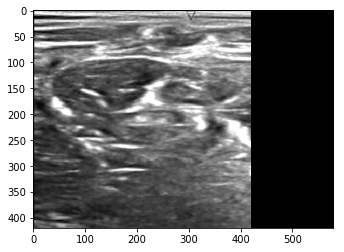

In [9]:
plt.figure()
plt.imshow(image_t[0],cmap='gray')

In [12]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)

In [13]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
def get_unet(inputs):
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu', padding='same')(inputs)
    conv1 = layers.Dropout(0.5)(conv1)
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Dropout(0.5)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(pool2)
    conv3 = layers.Dropout(0.5)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(pool3)
    conv4 = layers.Dropout(0.5)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3),
                          activation='relu', padding='same')(pool4)
    conv5 = layers.Dropout(0.5)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu',
                          padding='same')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Dropout(0.5)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Dropout(0.5)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Dropout(0.5)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Dropout(0.5)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    print((model.summary()))

    return model

In [15]:
def auto_encoder(inputs):
    conv1 = layers.Conv2D(32, (3, 3),
                          activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu',
                          padding='same')(pool2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu',
                          padding='same')(pool3)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3),
                          activation='relu', padding='same')(pool4)

    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5)

    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(up6)

    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(up7)

    up9 = layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(up8)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)

    model = Model(inputs=[inputs], outputs=[conv10])

    print((model.summary()))

    return Model(inputs=[inputs], outputs=[conv10])

In [16]:
z = layers.Input((train_image_rows, train_image_cols, 1))
unet = get_unet(z)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 96, 96, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

In [17]:
encod = auto_encoder(z)
encod.compile(optimizer=tf.keras.optimizers.Adam(lr=.0001), loss=dice_coef_loss, metrics=[
              dice_coef, mean_iou, 'accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
__________

In [18]:
combined = Model(z, encod.output)
combined.compile(optimizer=tf.keras.optimizers.Adam(lr=.0001),
                  loss=dice_coef_loss, metrics=[
              dice_coef, mean_iou, 'accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [19]:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=5, shuffle=True,
                             random_state=42).split(image_c[:, 0, 0], mask_c[:, 0, 0]))

In [20]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(
        name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    early_stopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    tb_hist = TensorBoard(log_dir='./logs',
                          histogram_freq=0, write_grads=True, write_images=True)
    return [mcp_save, reduce_lr_loss, early_stopping, tb_hist]

In [21]:
import pandas as pd
for j, (train_idx, val_idx) in enumerate(folds):
    now = time.localtime()
    s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                      now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
    #unet = get_unet()
    print('\nFold ', j)
    image_train_cv = image_c[train_idx]
    mask_train_cv = mask_c[train_idx]
    image_valid_cv = image_c[val_idx]
    mask_valid_cv = mask_c[val_idx]

    name_weights = "./LEE_final_model_fold_" + \
        str(j) + str(winodw_size) + "_weights.h5"
    callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

    history = combined.fit(image_train_cv, mask_train_cv, epochs=20, verbose=2, shuffle=True, validation_data=(
        image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

    if history.history['dice_coef'][-1] < 0.05:
        break
    df = pd.DataFrame({"loss": history.history['loss'],
                       "val_loss": history.history['val_loss'],
                       "mean_iou": history.history['mean_iou'],
                       "val_mean_iou": history.history['val_mean_iou'],
                       "dice_coef": history.history['dice_coef'],
                       "val_dice_coef": history.history['val_dice_coef'],
                       "precision": history.history['precision'],
                       "val_precision": history.history['val_precision'],
                       "recall": history.history['recall'],
                       "val_recall": history.history['val_recall']})
    df.to_csv(
        './history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
    print(combined.evaluate(image_valid_cv, mask_valid_cv, verbose=2))


Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/20
 - 23s - loss: 0.0078 - dice_coef: 0.0077 - mean_iou: 0.4877 - acc: 0.9709 - precision: 0.0151 - recall: 0.0210 - val_loss: 3.0322e-04 - val_dice_coef: 3.1417e-04 - val_mean_iou: 0.4938 - val_acc: 0.9876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
 - 7s - loss: 2.9670e-04 - dice_coef: 2.9669e-04 - mean_iou: 0.4940 - acc: 0.9876 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.1609e-04 - val_dice_coef: 3.9596e-04 - val_mean_iou: 0.4940 - val_acc: 0.9876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
 - 8s - loss: 2.9566e-04 - dice_coef: 2.9573e-04 - mean_iou: 0.4941 - acc: 0.9876 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0568e-04 - val_dice_coef: 3.4470e-04 - val_mean_iou: 0.4941 - val_acc: 0.9876 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
 - 7s - loss: 3.0118e-04 - dice_coef: 3.0153e-04 - mean_iou: 0.4941 - acc: 0.9876 - precision: 0.0

In [108]:
np.save('./image_FROST_11',image_c)

In [22]:
mask_predict = unet.predict(image_valid_cv, verbose=1)

1127/1127 [==============================] - ETA: 1: - ETA: 34s - ETA: 20 - ETA: 13 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 4ms/sample


In [23]:
mask_r = mask_predict.reshape(1127, 96, 96)
mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
image_test_u = image_valid_cv.reshape(1127, 96, 96)

In [24]:
img_test_o = (mask_r*2)+image_test_u
img_predict_o =image_test_u+(mask_test_u*2)

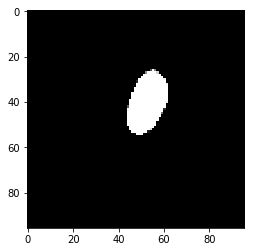

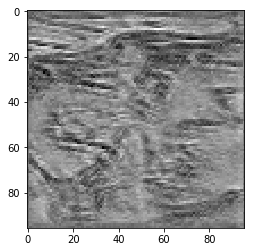

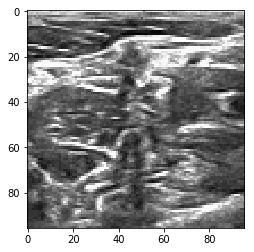

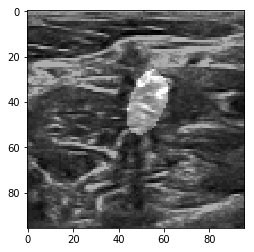

In [25]:
plt.figure()
plt.imshow(mask_test_u[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow( mask_r[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_test_o[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_predict_o[35], cmap='gray')
plt.show()